<a href="https://colab.research.google.com/github/nulven/PrivacyML/blob/master/Audio_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd '~/privacyml'

/home/nulven/privacyml


Preprocess data

In [2]:
%matplotlib inline
import time
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import pickle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets, models
from opacus import PrivacyEngine
import copy

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import MNIST, CIFAR10, ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader, Subset, Dataset
from torch.nn.utils import vector_to_parameters, parameters_to_vector

from sklearn.metrics import accuracy_score

torch.manual_seed(0)
np.random.seed(0)

In [3]:
batch_size=100
device = 'cuda:0' if torch.cuda.is_available else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

In [4]:
def check_memory(device):
    torch.cuda.get_device_properties(device)
    t = torch.cuda.get_device_properties(device).total_memory
    r = torch.cuda.memory_reserved(device) 
    a = torch.cuda.memory_allocated(device)
    f = r-a  # free inside reserved
    print(f)

In [5]:
#Audio Plots
from tqdm import tqdm 
import time 
'''
for aud in tqdm(audio):
  x , sr = librosa.load(audio_folder+'/'+aud)
  mfccs = librosa.feature.mfcc(x, sr=sr)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  ax = fig.add_subplot(111)
  librosa.display.specshow(mfccs, sr=sr)
  plt.margins(0,0)
  plt.axis('off')
  plt.savefig('/content/drive/MyDrive/csail/mnist/audio_plots/' + aud + '.png',bbox_inches='tight',pad_inches = 0)
  # time.sleep(0.01)
'''

"\nfor aud in tqdm(audio):\n  x , sr = librosa.load(audio_folder+'/'+aud)\n  mfccs = librosa.feature.mfcc(x, sr=sr)\n  fig = plt.Figure()\n  canvas = FigureCanvas(fig)\n  ax = fig.add_subplot(111)\n  librosa.display.specshow(mfccs, sr=sr)\n  plt.margins(0,0)\n  plt.axis('off')\n  plt.savefig('/content/drive/MyDrive/csail/mnist/audio_plots/' + aud + '.png',bbox_inches='tight',pad_inches = 0)\n  # time.sleep(0.01)\n"

In [6]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                # print("F1 Score = {}, Precision = {}, Recall = {}".format(f1(labels,preds),precision(labels,preds),recall(labels,preds)))

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [7]:
def train(model, train_dl, optimizer, criterion):
    model.to(device)
    model.train()
    batch_loss, batch_acc = [], []
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().cpu())
        pred = torch.argmax(logits, dim=1)
        batch_acc.append(accuracy_score(labels.cpu(), pred.cpu()))
    model.cpu()
    return sum(batch_loss)/len(batch_loss), sum(batch_acc)/len(batch_acc)

In [8]:
def test(model, test_dl, criterion):      
    with torch.no_grad():
        model.to(device)
        model.eval()
        batch_loss, batch_acc = [], []
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            batch_loss.append(loss.cpu())
            pred = torch.argmax(logits, dim=1)
            batch_acc.append(accuracy_score(labels.cpu(), pred.cpu()))
        model.cpu()
        return sum(batch_loss)/len(batch_loss), sum(batch_acc)/len(batch_acc)

In [9]:
def fit(epochs, model, optimizer,criterion, train_dl, test_dl):
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    for epoch in range(1,epochs+1):
        trainl, traina = train(model, train_dl, optimizer, criterion)
        testl , testa = test(model, test_dl, criterion)
        train_loss.append(trainl)
        train_acc.append(traina)
        test_loss.append(testl)
        test_acc.append(testa)
        print(f'Epoch {epoch} - train_loss : {trainl :.4f}, train_acc : {traina:.4f}, test_loss : {testl:.4f}, test_acc : {testa:0.4f}')

    history = {'train_loss' : train_loss,
               'train_acc' : train_acc,
               'test_loss' : test_loss,
               'test_acc' : test_acc}
    return history

In [10]:
def plot(epochs, title, history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    t = f.suptitle(title, fontsize=24)
    f.patch.set_facecolor('white')
    f.subplots_adjust(top=0.85, wspace=0.3)
    epoch_list = list(range(1,epochs+1))

    ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history['test_acc'], label='Test Accuracy')
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy', fontsize = 18)
    ax1.grid(True)
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
    ax2.plot(epoch_list, history['test_loss'], label='Test Loss')
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss', fontsize = 18)
    ax2.grid(True)
    l2 = ax2.legend(loc="best")
    return f

In [11]:
def save(history, model, figure, name):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(history, handle)
    torch.save(model, name + '.pth')
    figure.savefig(name + '.png')

In [12]:
def create_ds(labels, even=0):
    if even == 1:
        train_idxs = []
        validation_idxs = []
        for name in set(labels.name):
          for digit in range(10):
            idxs = labels[labels.name == name]
            idxs = idxs[idxs.label == digit].index
            train_idxs1, validation_idxs1 = torch.utils.data.random_split(list(idxs), [40, 10])
            train_idxs.extend(list(train_idxs1))
            validation_idxs.extend(list(validation_idxs1))
        train_set, validation_set = torch.utils.data.Subset(dataset, train_idxs), torch.utils.data.Subset(dataset, validation_idxs)
        train_ds, validation_ds = labels.iloc[train_idxs], labels.iloc[validation_idxs]
        validation_set = HeartbeatDataset("/data/mnist/audio_plots",validation_ds,transform=ds_trans)
        validation_dl = DataLoader(validation_set, 100, shuffle=True, num_workers=4, pin_memory=True)
    elif even == 2:
        train_idxs = []
        validation_idxs = []
        for digit in range(10):
            idxs = labels[labels.name == name]
            idxs = idxs[idxs.label == digit].index
            train_idxs1, validation_idxs1 = torch.utils.data.random_split(list(idxs), [240, 60])
            train_idxs.extend(list(train_idxs1))
            validation_idxs.extend(list(validation_idxs1))
        train_set, validation_set = torch.utils.data.Subset(dataset, train_idxs), torch.utils.data.Subset(dataset, validation_idxs)
        train_ds, validation_ds = labels.iloc[train_idxs], labels.iloc[validation_idxs]
        validation_set = HeartbeatDataset("/data/mnist/audio_plots",validation_ds,transform=ds_trans)
        validation_dl = DataLoader(validation_set, 100, shuffle=True, num_workers=4, pin_memory=True)
    else:
        train_idxs, validation_idxs = torch.utils.data.random_split(list(labels.index), [2400, 600])
        train_set, validation_set = torch.utils.data.Subset(dataset, train_idxs), torch.utils.data.Subset(dataset, validation_idxs)
        train_ds, validation_ds = labels.iloc[list(train_idxs)], labels.iloc[list(validation_idxs)]
        train_ds, validation_ds = train_ds.reset_index(drop=True), validation_ds.reset_index(drop=True)
        validation_set = HeartbeatDataset("/data/mnist/audio_plots",validation_ds,transform=ds_trans)
        validation_dl = DataLoader(validation_set, 100, shuffle=True, num_workers=4, pin_memory=True)
    return train_ds, validation_dl

In [13]:
def make_iid_dls(train_ds, n):
    size = len(train_ds)//n
    last_size = size + len(train_ds)%n
    client_ds = random_split(train_ds, [size]*(n-1) + [last_size])
    client_dls = [DataLoader(ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)for ds in client_ds]
    return client_dls

In [14]:
def make_noniid_dls(train_ds, n):
    num_shards, num_imgs = 2*n, len(train_ds)//(2*n)
    idx_shard = [i for i in range(num_shards)]
    dict_clients = {i: np.array([]) for i in range(n)}
    idxs = np.arange(num_shards*num_imgs)
    labels = train_ds.targets

    # sort labels
    idxs_labels = np.vstack((idxs, labels[:len(idxs)]))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    idxs = idxs_labels[0,:]

    # divide and assign
    for i in range(n):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_clients[i] = np.concatenate((dict_clients[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)

    client_dls = []
    for i in range(n):
        ds = Subset(train_ds, torch.LongTensor(dict_clients[i]))
        client_dls.append(DataLoader(ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True))
    return client_dls

In [15]:
def make_iid_dls_with_speakers(train_ds, n):
    train_ds = train_ds.reset_index(drop=True)
    size = len(train_ds)//n
    last_size = size + len(train_ds)%n
    client_idxs = random_split(list(train_ds.index), [size]*(n-1) + [last_size])
    client_dls = []
    for idxs in client_idxs:
        subset = train_ds.iloc[list(idxs)]
        subset = subset.reset_index(drop=True)
        ds = HeartbeatDataset("/data/mnist/audio_plots",subset,transform=ds_trans)
        client_dls.append(DataLoader(ds, 100, shuffle=True, num_workers=4, pin_memory=True))
    return client_dls

In [88]:
from itertools import combinations

def make_noniid_dls_with_speakers(train_ds, n, names_per_client, speakers=True, speaker_sets=None, digit_sets=None):
    client_dls = []
    if speakers:
        if not speaker_sets:
            speaker_sets = list(combinations(list(set(train_ds.name)), names_per_client))[:n]
        else:
            speaker_names = list(set(train_ds.name))
            speaker_sets = [[speaker_names[_] for _ in speaker_set] for speaker_set in speaker_sets]
        for name_set in speaker_sets:
            subset = train_ds[train_ds.name.isin(name_set)]
            subset = subset.reset_index(drop=True)
            print(str(name_set), len(subset))
            ds = HeartbeatDataset("/data/mnist/audio_plots",subset,transform=ds_trans)
            client_dls.append(DataLoader(ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True))
    else:
        if not digit_sets:
            digit_sets = [[_] for _ in range(10)]
        for digit_set in digit_sets:
            subset = train_ds[train_ds.label.isin(digit_set)]
            subset = subset.reset_index(drop=True)
            print(str(digit_set), len(subset))
            ds = HeartbeatDataset("/data/mnist/audio_plots",subset,transform=ds_trans)
            client_dls.append(DataLoader(ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True))
    print()
    return client_dls

In [17]:
def make_clients(n, model, optimizer):
    models = [model for _ in range(n)]
    optimizers = [optimizer for model in models]
    return models, optimizers

In [19]:
def add_noise(model):
    sigma = calibrateAnalyticGaussianMechanism(2, 10**(-5), .00001)
    normal_dist = torch.distributions.Normal(loc=torch.tensor([0.]), scale=torch.tensor([sigma**2]))
    for param in model.parameters():
        t = normal_dist.sample(param.size())
        t = t.view(-1).reshape(param.size())
        with torch.no_grad():
            if param.is_cuda:
                t = t.to(device)
            param.add_(t)
    return model

In [20]:
def train_clients(client_models, client_optimizers, server_model, criterion, client_dls):
    client_loss, client_acc = [], []
    for model, optimizer, train_dl in zip(client_models, client_optimizers, client_dls):
        model.load_state_dict(server_model.state_dict())
        closs, cacc = train(model, train_dl, optimizer, criterion)
        client_loss.append(closs)
        client_acc.append(cacc)
    return sum(client_loss)/len(client_loss), sum(client_acc)/len(client_acc)

In [21]:
def compute_gradient(client_models, server_model, r, compression,sparsity, warmup, epoch):
    n = len(client_models)
    server_dict = server_model.state_dict()
    grad_dict = {k : torch.zeros_like(v) for k, v in server_dict.items()}
    if compression is None:
        for model in client_models:
            client_dict = model.state_dict()
            for name in client_dict:
                grad_dict[name] += client_dict[name]
        grad_dict = {k : v/n-server_dict[k] for k,v in grad_dict.items()}
    else:
        if epoch <= warmup:
            scale = (sparsity/(1-1/n))**(1/warmup) if compression == 'rTopk' else (sparsity/0.00001)**(1/warmup)
            sparsity /= scale**(warmup-epoch+1)
        grad_vector = nn.utils.parameters_to_vector(grad_dict.values())
        count_vector = copy.deepcopy(grad_vector)
        for i, model in enumerate(client_models):
            client_dict =  model.state_dict()
            residual_dict = r[i]
            g = {k : client_dict[k] - server_dict[k] + residual_dict[k] for k in client_dict}
            g_vector = nn.utils.parameters_to_vector(g.values())
            if compression == "rTopk":
                _, rtop_idx = torch.topk(g_vector.abs(), int((1-sparsity)* len(g_vector))*n, sorted = False)
                topk_idx = np.random.choice(rtop_idx, len(rtop_idx)//n, replace = False)
            else:
                _, topk_idx = torch.topk(g_vector.abs(), int((1-sparsity)* len(g_vector)), sorted = False)
            residual_vector = copy.deepcopy(g_vector)
            residual_vector[topk_idx] = 0
            nn.utils.vector_to_parameters(residual_vector, residual_dict.values())
            grad_vector[topk_idx] += g_vector[topk_idx]
            count_vector[topk_idx] += 1
        count_vector[count_vector == 0] = 1
        grad_vector /= count_vector
        nn.utils.vector_to_parameters(grad_vector, grad_dict.values())
    return grad_dict

In [97]:
def train_server(model, opt, lr, g, m, v, beta1, beta2, epsilon, epoch, demon, total_epochs):
    s_dict = model.state_dict()
    if opt == 'sgd':
        new_s_dict = {k : s_dict[k] + lr * g[k] for k in s_dict}
    else:
        if demon:
            p = (1-epoch/total_epochs) 
            beta1 *= p/(1-beta1 + beta1*p)
            m = {k : beta1*m[k].cpu() + g[k].cpu() for k in g}
        else:
            m = {k : beta1*m[k].cpu() + (1-beta1)*g[k].cpu() for k in g}
        if opt == 'adagrad':
            v =  {k : v[k] + g[k]**2 for k in v}
        if opt == 'yogi':
            v = {k : v[k] - (1-beta2)*torch.sign(v[k] - g[k]**2)*(g[k]**2) for k in v}
        if opt == 'adam':
            v = {k : beta2*v[k].cpu() + (1-beta2)*(g[k].cpu()**2) for k in v}
        lr *= ((1-beta2**epoch)**0.5)/(1-beta1**epoch)
        new_s_dict = {k : s_dict[k].cpu() + lr * m[k].cpu()/(v[k].cpu()**0.5 + epsilon) for k in s_dict}
    model.load_state_dict(new_s_dict)
    return m, v

In [23]:
def fit_federated(epochs, client_models, client_optimizers, client_dls, 
                  server_model, server_opt, server_lr, test_dl, criterion,
                  beta1 = 0, beta2 = 0, epsilon = 1e-8, demon = False, compression = None, sparsity = 0, warmup = 5):
    s_dict = server_model.state_dict()
    m = {k : torch.zeros_like(v) for k, v in s_dict.items()}
    v = copy.deepcopy(m)
    r = [copy.deepcopy(m) for _ in range(len(client_models))]
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    for epoch in range(1,epochs+1):
        trainl, traina = train_clients(client_models, client_optimizers, server_model, criterion, client_dls)
        g = compute_gradient(client_models, server_model, r, compression, sparsity, warmup, epoch)
        m, v = train_server(server_model, server_opt, server_lr, g, m, v, beta1, beta2, epsilon, epoch, demon, epochs)
        testl , testa = test(server_model, test_dl, criterion)
        train_loss.append(trainl)
        train_acc.append(traina)
        test_loss.append(testl)
        test_acc.append(testa)
        print(f'Epoch {epoch} - train_loss : {trainl :.4f}, train_acc : {traina:.4f}, test_loss : {testl:.4f}, test_acc : {testa:0.4f}')

    history = {'train_loss' : train_loss,
               'train_acc' : train_acc,
               'test_loss' : test_loss,
               'test_acc' : test_acc}
    return history

In [24]:
from PIL import Image

class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 10, 5),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(10, 20, kernel_size=5),
                                   nn.Dropout2d(),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Linear(320, 50),
                                 nn.Dropout(),
                                 nn.ReLU())
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class HeartbeatDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = annotation_file
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id+'.png')).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1])).type(torch.LongTensor)

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

In [25]:
files = os.listdir('/data/mnist/audio_mnist')
digits = [int(file[0]) for file in files]
names = [file.split('_')[1] for file in files]
d = {'fname': files, 'label': digits, 'name': names}
labels = pd.DataFrame(data=d)
dataset = HeartbeatDataset("/data/mnist/audio_plots",labels,transform=ds_trans)

In [90]:
n = 5
train_ds, validation_dl = create_ds(labels, even=False)
iid_dls = make_iid_dls_with_speakers(train_ds, n)
noniid_speakers_dls = make_noniid_dls_with_speakers(train_ds, n, 2, speakers=True, speaker_sets=[{0,1},{1,2},{2,3},{3,4},{4,5}])
noniid_digits_dls = make_noniid_dls_with_speakers(train_ds, n, 3, speakers=False, digit_sets=[{0,1,6},{1,2,3,4,5},{0,1,2,3,4,5,6,7,8,9},{5,6,7},{2,3,4,8,9}, {0,6,7}])

['lucas', 'george'] 802
['george', 'nicolas'] 783
['nicolas', 'yweweler'] 797
['yweweler', 'theo'] 816
['theo', 'jackson'] 801

{0, 1, 6} 713
{1, 2, 3, 4, 5} 1209
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} 2400
{5, 6, 7} 720
{2, 3, 4, 8, 9} 1206
{0, 6, 7} 713



In [27]:
def forward_half(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x) # -> 112x112

    #x = self.layer1(x) # -> 56x56
    #x = self.layer2(x) # -> 28x28
    #x = self.layer3(x) # -> 14x14
    #x = self.layer4(x) # -> 7x7

    return x

# Experiments

## No DP

### IID-SGD-NODP

In [91]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(server_model.fc.parameters(), lr=0.05, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)
server_opt = 'sgd'
server_lr = 0.05
beta1 = 1
beta2 = 1
epsilon = 1e-8
epochs = 250

In [92]:
history = fit_federated(epochs, client_models, client_optimizers, iid_dls, 
                                server_model, server_opt, server_lr, validation_dl,
                                criterion, beta1, beta2, epsilon)

Epoch 1 - train_loss : 9.4503, train_acc : 0.1468, test_loss : 11.5338, test_acc : 0.1167
Epoch 2 - train_loss : 5.7042, train_acc : 0.3277, test_loss : 2.5310, test_acc : 0.4417
Epoch 3 - train_loss : 1.5607, train_acc : 0.5914, test_loss : 1.3002, test_acc : 0.6317
Epoch 4 - train_loss : 0.9961, train_acc : 0.6945, test_loss : 1.0805, test_acc : 0.6667
Epoch 5 - train_loss : 0.7937, train_acc : 0.7431, test_loss : 1.0593, test_acc : 0.6767
Epoch 6 - train_loss : 0.6967, train_acc : 0.7638, test_loss : 0.8644, test_acc : 0.7267
Epoch 7 - train_loss : 0.5802, train_acc : 0.8029, test_loss : 0.9630, test_acc : 0.7033
Epoch 8 - train_loss : 0.6638, train_acc : 0.7771, test_loss : 1.1942, test_acc : 0.6367
Epoch 9 - train_loss : 0.5175, train_acc : 0.8205, test_loss : 0.9737, test_acc : 0.7067
Epoch 10 - train_loss : 0.5404, train_acc : 0.8098, test_loss : 1.0244, test_acc : 0.6800
Epoch 11 - train_loss : 0.5931, train_acc : 0.8086, test_loss : 0.9670, test_acc : 0.6967
Epoch 12 - train_l

Epoch 93 - train_loss : 0.0479, train_acc : 0.9927, test_loss : 0.7186, test_acc : 0.8000
Epoch 94 - train_loss : 0.0498, train_acc : 0.9897, test_loss : 0.7750, test_acc : 0.7900
Epoch 95 - train_loss : 0.0629, train_acc : 0.9871, test_loss : 0.7531, test_acc : 0.7983
Epoch 96 - train_loss : 0.0543, train_acc : 0.9891, test_loss : 0.7130, test_acc : 0.7900
Epoch 97 - train_loss : 0.0487, train_acc : 0.9943, test_loss : 0.7092, test_acc : 0.7867
Epoch 98 - train_loss : 0.0416, train_acc : 0.9946, test_loss : 0.7127, test_acc : 0.7933
Epoch 99 - train_loss : 0.0406, train_acc : 0.9955, test_loss : 0.7221, test_acc : 0.7900
Epoch 100 - train_loss : 0.0480, train_acc : 0.9901, test_loss : 0.7428, test_acc : 0.7850
Epoch 101 - train_loss : 0.0413, train_acc : 0.9954, test_loss : 0.7155, test_acc : 0.7950
Epoch 102 - train_loss : 0.0371, train_acc : 0.9956, test_loss : 0.6946, test_acc : 0.7983
Epoch 103 - train_loss : 0.0441, train_acc : 0.9955, test_loss : 0.6952, test_acc : 0.7883
Epoch 

Epoch 184 - train_loss : 0.0334, train_acc : 0.9969, test_loss : 0.7518, test_acc : 0.7933
Epoch 185 - train_loss : 0.0282, train_acc : 0.9974, test_loss : 0.7913, test_acc : 0.7950
Epoch 186 - train_loss : 0.0253, train_acc : 0.9981, test_loss : 0.7650, test_acc : 0.8000
Epoch 187 - train_loss : 0.0254, train_acc : 0.9974, test_loss : 0.7501, test_acc : 0.7967
Epoch 188 - train_loss : 0.0248, train_acc : 0.9992, test_loss : 0.7651, test_acc : 0.8033
Epoch 189 - train_loss : 0.0250, train_acc : 0.9975, test_loss : 0.7461, test_acc : 0.8083
Epoch 190 - train_loss : 0.0331, train_acc : 0.9926, test_loss : 0.7783, test_acc : 0.7833
Epoch 191 - train_loss : 0.0240, train_acc : 0.9983, test_loss : 0.7473, test_acc : 0.7950
Epoch 192 - train_loss : 0.0247, train_acc : 0.9984, test_loss : 0.7605, test_acc : 0.7950
Epoch 193 - train_loss : 0.0244, train_acc : 0.9984, test_loss : 0.7902, test_acc : 0.7983
Epoch 194 - train_loss : 0.0203, train_acc : 0.9992, test_loss : 0.7676, test_acc : 0.7983

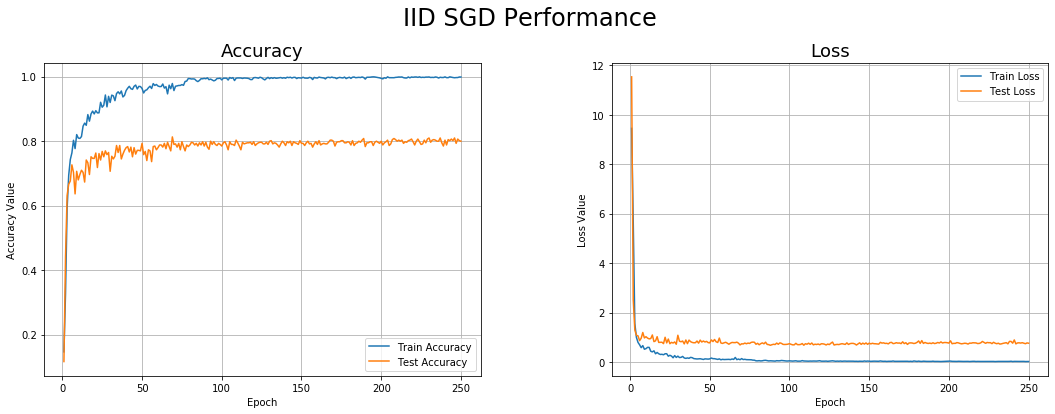

In [93]:
f = plot(epochs, "IID SGD Performance", history)

In [94]:
save(history, server_model, f, "IID_SGD")

### NONIID-SGD-NODP-SPEAKERS

In [114]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'sgd'
server_lr = 0.05
beta1 = 1
beta2 = 1
epsilon = 1e-8
demon=False
epochs = 300

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(server_model.fc.parameters(), lr=0.05, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

In [115]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_speakers_dls, 
                                   server_model, server_opt, server_lr, validation_dl,
                                   criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 9.3230, train_acc : 0.1754, test_loss : 23.7596, test_acc : 0.0983
Epoch 2 - train_loss : 7.6073, train_acc : 0.4017, test_loss : 7.0244, test_acc : 0.2367
Epoch 3 - train_loss : 3.4800, train_acc : 0.5317, test_loss : 9.9726, test_acc : 0.2083
Epoch 4 - train_loss : 4.8400, train_acc : 0.4861, test_loss : 14.4074, test_acc : 0.1967
Epoch 5 - train_loss : 5.6534, train_acc : 0.5366, test_loss : 8.8363, test_acc : 0.2367
Epoch 6 - train_loss : 2.7567, train_acc : 0.6466, test_loss : 7.4300, test_acc : 0.3267
Epoch 7 - train_loss : 2.8210, train_acc : 0.6607, test_loss : 12.3090, test_acc : 0.1983
Epoch 8 - train_loss : 4.6623, train_acc : 0.5308, test_loss : 8.2738, test_acc : 0.3783
Epoch 9 - train_loss : 3.4436, train_acc : 0.6789, test_loss : 5.3708, test_acc : 0.4133
Epoch 10 - train_loss : 2.9545, train_acc : 0.6195, test_loss : 4.5842, test_acc : 0.5133
Epoch 11 - train_loss : 3.7404, train_acc : 0.6052, test_loss : 7.8417, test_acc : 0.3583
Epoch 12 - train

Epoch 93 - train_loss : 3.5930, train_acc : 0.7745, test_loss : 6.0388, test_acc : 0.6467
Epoch 94 - train_loss : 3.9954, train_acc : 0.7263, test_loss : 6.6926, test_acc : 0.6250
Epoch 95 - train_loss : 2.8437, train_acc : 0.8019, test_loss : 4.7422, test_acc : 0.6850
Epoch 96 - train_loss : 3.5373, train_acc : 0.7599, test_loss : 4.8948, test_acc : 0.6767
Epoch 97 - train_loss : 1.2189, train_acc : 0.8821, test_loss : 5.7958, test_acc : 0.6600
Epoch 98 - train_loss : 0.9804, train_acc : 0.8707, test_loss : 5.6074, test_acc : 0.6467
Epoch 99 - train_loss : 2.5222, train_acc : 0.7797, test_loss : 6.9474, test_acc : 0.6067
Epoch 100 - train_loss : 4.2794, train_acc : 0.7516, test_loss : 4.5780, test_acc : 0.7317
Epoch 101 - train_loss : 1.3014, train_acc : 0.8504, test_loss : 7.1375, test_acc : 0.6200
Epoch 102 - train_loss : 2.3730, train_acc : 0.8191, test_loss : 8.2984, test_acc : 0.5833
Epoch 103 - train_loss : 4.7035, train_acc : 0.7379, test_loss : 8.2011, test_acc : 0.5817
Epoch 

Epoch 184 - train_loss : 4.3853, train_acc : 0.7853, test_loss : 5.1455, test_acc : 0.7283
Epoch 185 - train_loss : 3.6027, train_acc : 0.8059, test_loss : 7.0940, test_acc : 0.6533
Epoch 186 - train_loss : 3.5886, train_acc : 0.8035, test_loss : 6.0869, test_acc : 0.7033
Epoch 187 - train_loss : 1.7207, train_acc : 0.8612, test_loss : 5.1704, test_acc : 0.7200
Epoch 188 - train_loss : 1.7848, train_acc : 0.8628, test_loss : 5.6872, test_acc : 0.7117
Epoch 189 - train_loss : 2.9804, train_acc : 0.8026, test_loss : 5.4575, test_acc : 0.7200
Epoch 190 - train_loss : 4.5720, train_acc : 0.7794, test_loss : 5.6732, test_acc : 0.7133
Epoch 191 - train_loss : 3.4586, train_acc : 0.7986, test_loss : 6.0894, test_acc : 0.6767
Epoch 192 - train_loss : 2.0031, train_acc : 0.8528, test_loss : 6.0741, test_acc : 0.6817
Epoch 193 - train_loss : 2.4119, train_acc : 0.8336, test_loss : 5.8231, test_acc : 0.7217
Epoch 194 - train_loss : 2.0801, train_acc : 0.8787, test_loss : 4.4093, test_acc : 0.7533

Epoch 275 - train_loss : 1.4449, train_acc : 0.8971, test_loss : 5.4573, test_acc : 0.7467
Epoch 276 - train_loss : 1.8181, train_acc : 0.8862, test_loss : 5.8991, test_acc : 0.7333
Epoch 277 - train_loss : 2.2570, train_acc : 0.8689, test_loss : 4.9034, test_acc : 0.7567
Epoch 278 - train_loss : 2.8390, train_acc : 0.8532, test_loss : 7.6975, test_acc : 0.6683
Epoch 279 - train_loss : 3.0712, train_acc : 0.8266, test_loss : 6.3346, test_acc : 0.7133
Epoch 280 - train_loss : 2.9224, train_acc : 0.8343, test_loss : 5.9696, test_acc : 0.7217
Epoch 281 - train_loss : 2.6589, train_acc : 0.8610, test_loss : 6.2341, test_acc : 0.7283
Epoch 282 - train_loss : 2.3725, train_acc : 0.8770, test_loss : 5.3800, test_acc : 0.7217
Epoch 283 - train_loss : 0.8809, train_acc : 0.9032, test_loss : 5.6212, test_acc : 0.7517
Epoch 284 - train_loss : 4.0664, train_acc : 0.8093, test_loss : 5.8931, test_acc : 0.7367
Epoch 285 - train_loss : 3.5220, train_acc : 0.8081, test_loss : 5.7096, test_acc : 0.7283

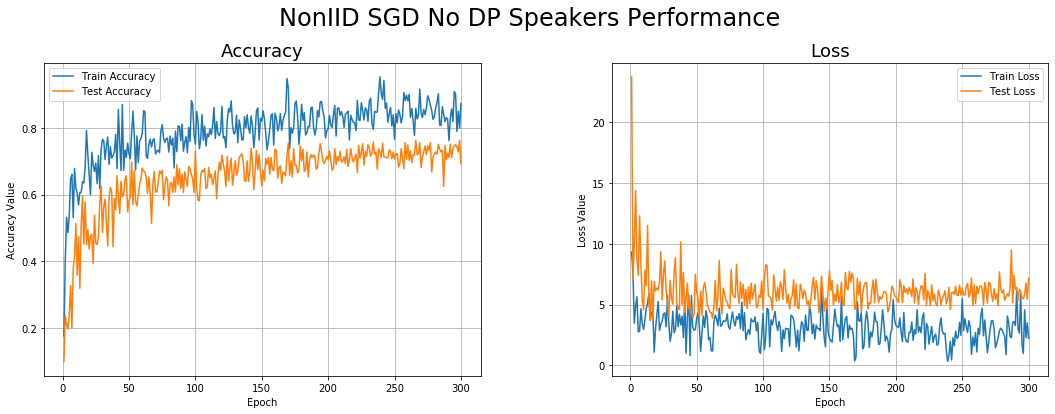

In [117]:
f = plot(epochs, "NonIID SGD No DP Speakers Performance", history)

In [118]:
save(history, server_model, f, "NONIID_SGD_NODP_SPEAKERS")

### NONIID-SGD-NODP-DIGITS

In [119]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'sgd'
server_lr = 0.05
beta1 = 1
beta2 = 1
epsilon = 1e-8
demon=False
epochs = 300

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(server_model.fc.parameters(), lr=0.05, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

In [120]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_digits_dls, 
                                   server_model, server_opt, server_lr, validation_dl,
                                   criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 15.3050, train_acc : 0.2792, test_loss : 78.6175, test_acc : 0.1583
Epoch 2 - train_loss : 46.8376, train_acc : 0.3205, test_loss : 59.0330, test_acc : 0.3700
Epoch 3 - train_loss : 37.8057, train_acc : 0.3951, test_loss : 86.7120, test_acc : 0.3583
Epoch 4 - train_loss : 45.3941, train_acc : 0.3997, test_loss : 70.6246, test_acc : 0.3100
Epoch 5 - train_loss : 45.7736, train_acc : 0.3486, test_loss : 87.2655, test_acc : 0.3783
Epoch 6 - train_loss : 47.7318, train_acc : 0.3838, test_loss : 67.9500, test_acc : 0.3817
Epoch 7 - train_loss : 37.4808, train_acc : 0.4228, test_loss : 64.0207, test_acc : 0.3933
Epoch 8 - train_loss : 38.5277, train_acc : 0.4509, test_loss : 62.2404, test_acc : 0.3550
Epoch 9 - train_loss : 31.4806, train_acc : 0.4983, test_loss : 50.9003, test_acc : 0.3900
Epoch 10 - train_loss : 29.4986, train_acc : 0.4858, test_loss : 48.9779, test_acc : 0.3767
Epoch 11 - train_loss : 30.4673, train_acc : 0.4993, test_loss : 60.5028, test_acc : 0.33

Epoch 91 - train_loss : 9.0319, train_acc : 0.7393, test_loss : 18.2894, test_acc : 0.5767
Epoch 92 - train_loss : 8.1086, train_acc : 0.7622, test_loss : 13.8265, test_acc : 0.6450
Epoch 93 - train_loss : 6.9149, train_acc : 0.7621, test_loss : 15.1970, test_acc : 0.6100
Epoch 94 - train_loss : 8.2972, train_acc : 0.7475, test_loss : 14.9629, test_acc : 0.6083
Epoch 95 - train_loss : 8.3644, train_acc : 0.7582, test_loss : 18.7699, test_acc : 0.5817
Epoch 96 - train_loss : 8.8719, train_acc : 0.7485, test_loss : 14.9273, test_acc : 0.6017
Epoch 97 - train_loss : 7.4515, train_acc : 0.7636, test_loss : 14.5762, test_acc : 0.6117
Epoch 98 - train_loss : 8.0490, train_acc : 0.7571, test_loss : 13.9918, test_acc : 0.6117
Epoch 99 - train_loss : 7.7827, train_acc : 0.7564, test_loss : 13.3059, test_acc : 0.6283
Epoch 100 - train_loss : 6.9057, train_acc : 0.7751, test_loss : 12.2893, test_acc : 0.6467
Epoch 101 - train_loss : 6.3007, train_acc : 0.7845, test_loss : 13.9822, test_acc : 0.60

Epoch 181 - train_loss : 1.7484, train_acc : 0.8851, test_loss : 6.4917, test_acc : 0.7433
Epoch 182 - train_loss : 1.9021, train_acc : 0.8811, test_loss : 5.9138, test_acc : 0.7400
Epoch 183 - train_loss : 1.6009, train_acc : 0.8978, test_loss : 5.6073, test_acc : 0.7650
Epoch 184 - train_loss : 1.6630, train_acc : 0.8904, test_loss : 5.8215, test_acc : 0.7650
Epoch 185 - train_loss : 1.2293, train_acc : 0.9102, test_loss : 5.6702, test_acc : 0.7767
Epoch 186 - train_loss : 1.3220, train_acc : 0.9065, test_loss : 4.9411, test_acc : 0.7917
Epoch 187 - train_loss : 1.3459, train_acc : 0.9004, test_loss : 6.4493, test_acc : 0.7417
Epoch 188 - train_loss : 1.7254, train_acc : 0.8984, test_loss : 5.1386, test_acc : 0.7767
Epoch 189 - train_loss : 1.9083, train_acc : 0.8843, test_loss : 5.7320, test_acc : 0.7450
Epoch 190 - train_loss : 1.4601, train_acc : 0.8927, test_loss : 5.8496, test_acc : 0.7533
Epoch 191 - train_loss : 1.5711, train_acc : 0.8914, test_loss : 5.0425, test_acc : 0.7733

Epoch 272 - train_loss : 0.8723, train_acc : 0.9295, test_loss : 4.6643, test_acc : 0.7967
Epoch 273 - train_loss : 0.8668, train_acc : 0.9232, test_loss : 4.4223, test_acc : 0.8017
Epoch 274 - train_loss : 0.5312, train_acc : 0.9469, test_loss : 4.6039, test_acc : 0.8050
Epoch 275 - train_loss : 0.8002, train_acc : 0.9280, test_loss : 4.5100, test_acc : 0.8050
Epoch 276 - train_loss : 0.4185, train_acc : 0.9524, test_loss : 4.6152, test_acc : 0.8083
Epoch 277 - train_loss : 0.7262, train_acc : 0.9421, test_loss : 4.8667, test_acc : 0.8017
Epoch 278 - train_loss : 0.6820, train_acc : 0.9334, test_loss : 4.2934, test_acc : 0.8100
Epoch 279 - train_loss : 0.7836, train_acc : 0.9338, test_loss : 5.2749, test_acc : 0.7783
Epoch 280 - train_loss : 0.6040, train_acc : 0.9392, test_loss : 4.7217, test_acc : 0.7883
Epoch 281 - train_loss : 1.1903, train_acc : 0.9074, test_loss : 4.5994, test_acc : 0.7767
Epoch 282 - train_loss : 1.6948, train_acc : 0.8853, test_loss : 5.9506, test_acc : 0.7450

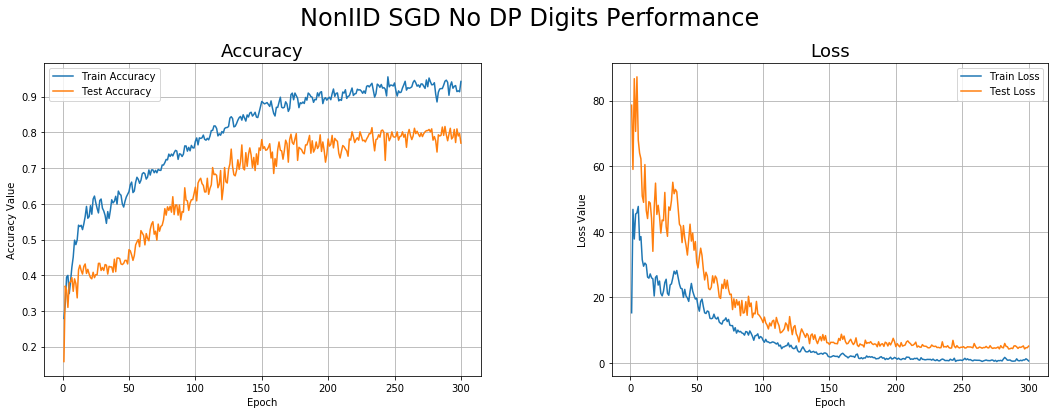

In [121]:
f = plot(epochs, "NonIID SGD No DP Digits Performance", history)

In [122]:
save(history, server_model, f, "NONIID_SGD_NODP_DIGITS")

### NONIID-ADAM-NODP-SPEAKERS

In [123]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon=False
epochs = 250

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(server_model.fc.parameters(), lr=0.003, betas=(beta1,beta2))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

In [124]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_speakers_dls, 
                                   server_model, server_opt, server_lr, validation_dl,
                                   criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 2.3092, train_acc : 0.2359, test_loss : 2.2103, test_acc : 0.1583
Epoch 2 - train_loss : 1.7460, train_acc : 0.4305, test_loss : 1.5097, test_acc : 0.4650
Epoch 3 - train_loss : 1.3971, train_acc : 0.5194, test_loss : 1.4507, test_acc : 0.4833
Epoch 4 - train_loss : 1.3283, train_acc : 0.5633, test_loss : 1.7044, test_acc : 0.3900
Epoch 5 - train_loss : 1.4373, train_acc : 0.5339, test_loss : 2.4274, test_acc : 0.2683
Epoch 6 - train_loss : 1.2611, train_acc : 0.6216, test_loss : 1.4119, test_acc : 0.5050
Epoch 7 - train_loss : 1.0260, train_acc : 0.6791, test_loss : 1.4571, test_acc : 0.4967
Epoch 8 - train_loss : 1.0487, train_acc : 0.6625, test_loss : 1.2984, test_acc : 0.5383
Epoch 9 - train_loss : 1.1104, train_acc : 0.6305, test_loss : 1.6699, test_acc : 0.4583
Epoch 10 - train_loss : 1.0115, train_acc : 0.6843, test_loss : 1.3137, test_acc : 0.5567
Epoch 11 - train_loss : 0.9236, train_acc : 0.7012, test_loss : 1.2881, test_acc : 0.5633
Epoch 12 - train_lo

Epoch 93 - train_loss : 0.4603, train_acc : 0.8550, test_loss : 0.9074, test_acc : 0.7317
Epoch 94 - train_loss : 0.4722, train_acc : 0.8545, test_loss : 1.0409, test_acc : 0.6983
Epoch 95 - train_loss : 0.6972, train_acc : 0.7864, test_loss : 1.3259, test_acc : 0.6483
Epoch 96 - train_loss : 0.4885, train_acc : 0.8321, test_loss : 1.0479, test_acc : 0.6983
Epoch 97 - train_loss : 0.8523, train_acc : 0.7639, test_loss : 1.3458, test_acc : 0.6300
Epoch 98 - train_loss : 0.5832, train_acc : 0.8233, test_loss : 0.8995, test_acc : 0.7333
Epoch 99 - train_loss : 0.5431, train_acc : 0.8139, test_loss : 1.1779, test_acc : 0.6900
Epoch 100 - train_loss : 0.5126, train_acc : 0.8483, test_loss : 1.1568, test_acc : 0.6833
Epoch 101 - train_loss : 0.5284, train_acc : 0.8474, test_loss : 1.0885, test_acc : 0.6917
Epoch 102 - train_loss : 0.5223, train_acc : 0.8294, test_loss : 1.1546, test_acc : 0.6883
Epoch 103 - train_loss : 0.4725, train_acc : 0.8455, test_loss : 1.0278, test_acc : 0.7067
Epoch 

Epoch 184 - train_loss : 0.5341, train_acc : 0.8529, test_loss : 1.2557, test_acc : 0.7000
Epoch 185 - train_loss : 0.7889, train_acc : 0.7934, test_loss : 1.3125, test_acc : 0.6767
Epoch 186 - train_loss : 0.5198, train_acc : 0.8429, test_loss : 1.1147, test_acc : 0.7183
Epoch 187 - train_loss : 0.3881, train_acc : 0.8742, test_loss : 1.0955, test_acc : 0.7300
Epoch 188 - train_loss : 0.5402, train_acc : 0.8446, test_loss : 1.1328, test_acc : 0.7267
Epoch 189 - train_loss : 0.4336, train_acc : 0.8699, test_loss : 1.1146, test_acc : 0.7167
Epoch 190 - train_loss : 0.3856, train_acc : 0.8650, test_loss : 1.0803, test_acc : 0.7183
Epoch 191 - train_loss : 0.3926, train_acc : 0.8717, test_loss : 1.5245, test_acc : 0.6633
Epoch 192 - train_loss : 0.4223, train_acc : 0.8702, test_loss : 1.1700, test_acc : 0.7100
Epoch 193 - train_loss : 0.3428, train_acc : 0.8898, test_loss : 1.1463, test_acc : 0.7100
Epoch 194 - train_loss : 0.4567, train_acc : 0.8508, test_loss : 1.2172, test_acc : 0.7000

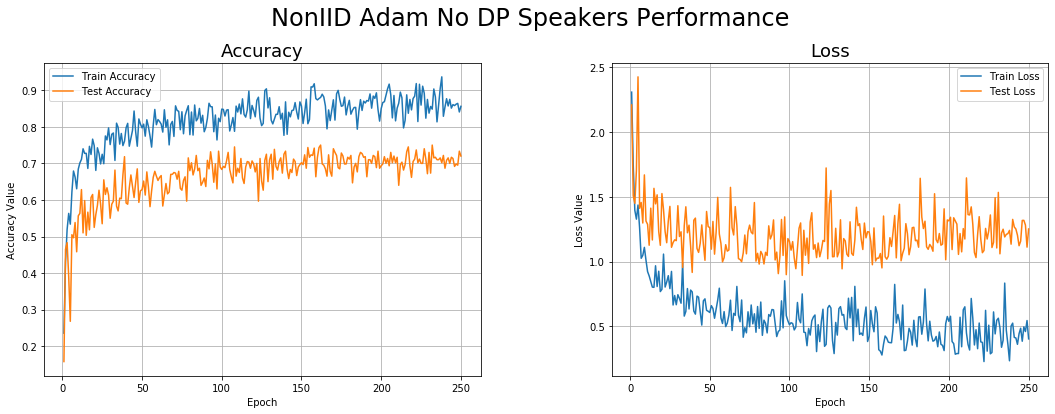

In [125]:
f = plot(epochs, "NonIID Adam No DP Speakers Performance", history)

In [126]:
save(history, server_model, f, "NONIID_ADAM_NODP_SPEAKERS")

### NONIID-ADAM-NODP-DIGITS

In [152]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon=False
epochs = 300

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(server_model.fc.parameters(), lr=0.003, betas=(beta1,beta2))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

In [ ]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_digits_dls, 
                                   server_model, server_opt, server_lr, validation_dl,
                                   criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 4.0432, train_acc : 0.2925, test_loss : 7.6590, test_acc : 0.2667
Epoch 2 - train_loss : 4.9365, train_acc : 0.2758, test_loss : 7.7033, test_acc : 0.2367
Epoch 3 - train_loss : 4.7501, train_acc : 0.3360, test_loss : 8.1678, test_acc : 0.3067
Epoch 4 - train_loss : 4.9549, train_acc : 0.3213, test_loss : 7.3917, test_acc : 0.3083
Epoch 5 - train_loss : 4.4893, train_acc : 0.3624, test_loss : 6.8832, test_acc : 0.3583
Epoch 6 - train_loss : 4.3398, train_acc : 0.3848, test_loss : 6.9819, test_acc : 0.3683
Epoch 7 - train_loss : 4.0796, train_acc : 0.4131, test_loss : 6.5097, test_acc : 0.3717
Epoch 8 - train_loss : 3.9122, train_acc : 0.4169, test_loss : 7.0609, test_acc : 0.3917
Epoch 9 - train_loss : 4.2513, train_acc : 0.3988, test_loss : 6.5058, test_acc : 0.3967
Epoch 10 - train_loss : 3.8624, train_acc : 0.4031, test_loss : 6.6534, test_acc : 0.3600
Epoch 11 - train_loss : 3.6823, train_acc : 0.4508, test_loss : 6.6096, test_acc : 0.4133
Epoch 12 - train_lo

Epoch 93 - train_loss : 1.6743, train_acc : 0.7015, test_loss : 3.4010, test_acc : 0.5100
Epoch 94 - train_loss : 1.7358, train_acc : 0.6846, test_loss : 3.7647, test_acc : 0.5117
Epoch 95 - train_loss : 1.7658, train_acc : 0.7023, test_loss : 3.0521, test_acc : 0.5267
Epoch 96 - train_loss : 1.6297, train_acc : 0.7003, test_loss : 4.3099, test_acc : 0.4850
Epoch 97 - train_loss : 1.9654, train_acc : 0.6940, test_loss : 3.2577, test_acc : 0.5267
Epoch 98 - train_loss : 1.6143, train_acc : 0.7173, test_loss : 3.2586, test_acc : 0.5317
Epoch 99 - train_loss : 1.6622, train_acc : 0.7006, test_loss : 3.3371, test_acc : 0.5267
Epoch 100 - train_loss : 1.6482, train_acc : 0.7125, test_loss : 3.1240, test_acc : 0.5317
Epoch 101 - train_loss : 1.5454, train_acc : 0.7179, test_loss : 3.2656, test_acc : 0.5267
Epoch 102 - train_loss : 1.4687, train_acc : 0.7329, test_loss : 3.5309, test_acc : 0.5417
Epoch 103 - train_loss : 1.5123, train_acc : 0.7311, test_loss : 2.8719, test_acc : 0.5617
Epoch 

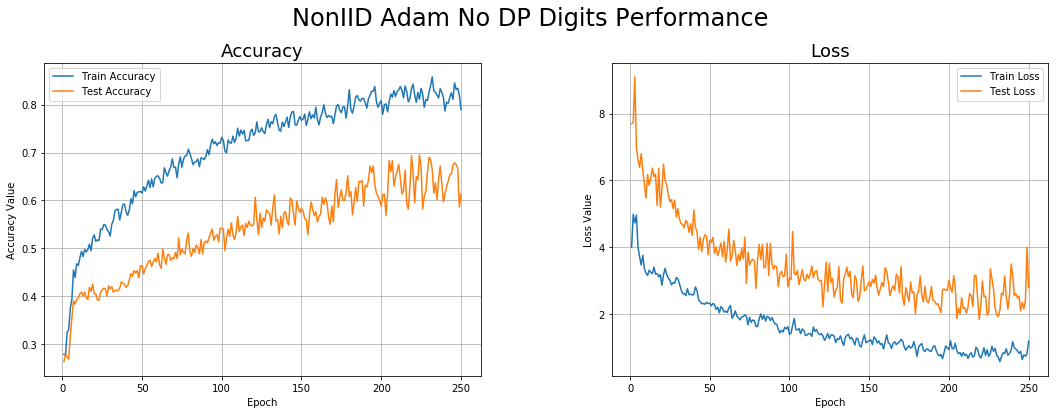

In [129]:
f = plot(epochs, "NonIID Adam No DP Digits Performance", history)

In [130]:
save(history, server_model, f, "NONIID_ADAM_NODP_DIGITS")

### NONIID-DEMONADAM-NODP-SPEAKERS

In [131]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon=True
epochs = 250

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(server_model.fc.parameters(), lr=0.003, betas=(beta1,beta2))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

In [132]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_speakers_dls, 
                                   server_model, server_opt, server_lr, validation_dl,
                                   criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 2.2160, train_acc : 0.2375, test_loss : 1.8879, test_acc : 0.2833
Epoch 2 - train_loss : 1.5984, train_acc : 0.4674, test_loss : 1.6137, test_acc : 0.4300
Epoch 3 - train_loss : 1.4161, train_acc : 0.5162, test_loss : 1.6198, test_acc : 0.4333
Epoch 4 - train_loss : 1.2783, train_acc : 0.5572, test_loss : 1.4082, test_acc : 0.4933
Epoch 5 - train_loss : 1.2218, train_acc : 0.5812, test_loss : 1.5999, test_acc : 0.4317
Epoch 6 - train_loss : 1.1710, train_acc : 0.6105, test_loss : 1.7286, test_acc : 0.4267
Epoch 7 - train_loss : 1.1221, train_acc : 0.6389, test_loss : 1.2214, test_acc : 0.5700
Epoch 8 - train_loss : 1.1788, train_acc : 0.6407, test_loss : 2.0793, test_acc : 0.3583
Epoch 9 - train_loss : 1.1246, train_acc : 0.6457, test_loss : 2.1553, test_acc : 0.3567
Epoch 10 - train_loss : 1.0603, train_acc : 0.6855, test_loss : 2.1502, test_acc : 0.3617
Epoch 11 - train_loss : 0.9484, train_acc : 0.7138, test_loss : 1.3339, test_acc : 0.5583
Epoch 12 - train_lo

Epoch 93 - train_loss : 0.7494, train_acc : 0.7601, test_loss : 1.4878, test_acc : 0.5967
Epoch 94 - train_loss : 0.7722, train_acc : 0.7397, test_loss : 1.2451, test_acc : 0.6150
Epoch 95 - train_loss : 0.5349, train_acc : 0.8400, test_loss : 1.0946, test_acc : 0.6667
Epoch 96 - train_loss : 0.7937, train_acc : 0.7495, test_loss : 1.1476, test_acc : 0.6467
Epoch 97 - train_loss : 0.8181, train_acc : 0.7361, test_loss : 1.1932, test_acc : 0.6317
Epoch 98 - train_loss : 0.5326, train_acc : 0.8294, test_loss : 1.1655, test_acc : 0.6633
Epoch 99 - train_loss : 0.5091, train_acc : 0.8219, test_loss : 1.2346, test_acc : 0.6417
Epoch 100 - train_loss : 0.5418, train_acc : 0.8212, test_loss : 1.1364, test_acc : 0.6517
Epoch 101 - train_loss : 0.7651, train_acc : 0.7564, test_loss : 1.1339, test_acc : 0.6317
Epoch 102 - train_loss : 0.7266, train_acc : 0.7776, test_loss : 1.1378, test_acc : 0.6533
Epoch 103 - train_loss : 0.9327, train_acc : 0.7228, test_loss : 1.6935, test_acc : 0.5933
Epoch 

Epoch 184 - train_loss : 0.5946, train_acc : 0.8452, test_loss : 1.2165, test_acc : 0.6950
Epoch 185 - train_loss : 0.7023, train_acc : 0.7994, test_loss : 0.8993, test_acc : 0.7233
Epoch 186 - train_loss : 0.6394, train_acc : 0.8015, test_loss : 1.2194, test_acc : 0.6883
Epoch 187 - train_loss : 0.4150, train_acc : 0.8682, test_loss : 1.0414, test_acc : 0.7233
Epoch 188 - train_loss : 0.5230, train_acc : 0.8455, test_loss : 0.9562, test_acc : 0.7233
Epoch 189 - train_loss : 0.4198, train_acc : 0.8570, test_loss : 1.2541, test_acc : 0.6717
Epoch 190 - train_loss : 0.6336, train_acc : 0.8281, test_loss : 1.1304, test_acc : 0.7017
Epoch 191 - train_loss : 0.6990, train_acc : 0.8059, test_loss : 1.1876, test_acc : 0.7050
Epoch 192 - train_loss : 0.4969, train_acc : 0.8448, test_loss : 1.0889, test_acc : 0.6950
Epoch 193 - train_loss : 0.4307, train_acc : 0.8602, test_loss : 1.1966, test_acc : 0.6783
Epoch 194 - train_loss : 0.4520, train_acc : 0.8657, test_loss : 1.0376, test_acc : 0.6900

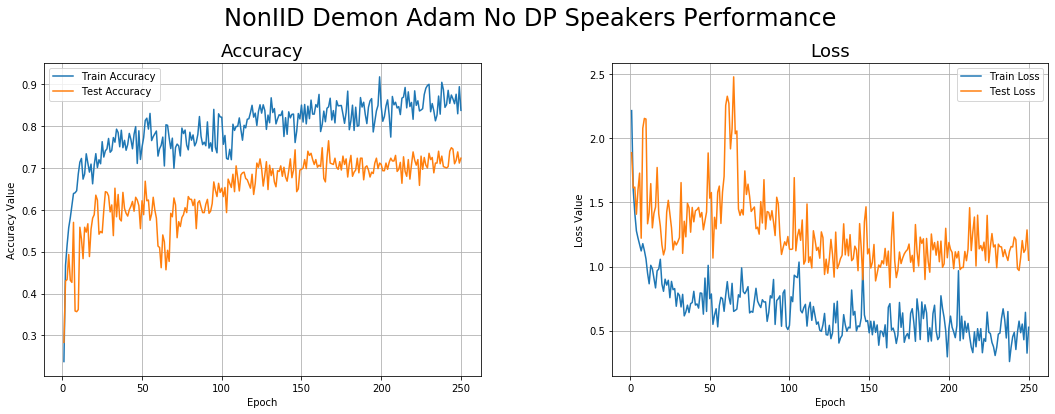

In [133]:
f = plot(epochs, "NonIID Demon Adam No DP Speakers Performance", history)

In [134]:
save(history, server_model, f, "NONIID_DEMON_ADAM_NODP_SPEAKERS")

### NONIID-DEMONADAM-NODP-DIGITS

In [135]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon=True
epochs = 250

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(server_model.fc.parameters(), lr=server_lr, betas=(beta1,beta2))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

In [136]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_digits_dls, 
                                server_model, server_opt, server_lr, validation_dl,
                                criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 4.3008, train_acc : 0.2751, test_loss : 8.9840, test_acc : 0.1733
Epoch 2 - train_loss : 5.4964, train_acc : 0.2679, test_loss : 7.4973, test_acc : 0.2533
Epoch 3 - train_loss : 4.6596, train_acc : 0.3301, test_loss : 7.0668, test_acc : 0.2383
Epoch 4 - train_loss : 4.0408, train_acc : 0.3432, test_loss : 6.9024, test_acc : 0.3000
Epoch 5 - train_loss : 3.9515, train_acc : 0.3884, test_loss : 6.6559, test_acc : 0.3867
Epoch 6 - train_loss : 3.8459, train_acc : 0.4027, test_loss : 7.3170, test_acc : 0.3100
Epoch 7 - train_loss : 3.8264, train_acc : 0.4161, test_loss : 6.8135, test_acc : 0.3883
Epoch 8 - train_loss : 3.7575, train_acc : 0.4246, test_loss : 6.4445, test_acc : 0.3750
Epoch 9 - train_loss : 3.5164, train_acc : 0.4359, test_loss : 6.2636, test_acc : 0.3667
Epoch 10 - train_loss : 3.3543, train_acc : 0.4768, test_loss : 6.2530, test_acc : 0.3933
Epoch 11 - train_loss : 3.3483, train_acc : 0.4806, test_loss : 6.1614, test_acc : 0.3833
Epoch 12 - train_lo

Epoch 93 - train_loss : 2.3941, train_acc : 0.6202, test_loss : 3.8513, test_acc : 0.5100
Epoch 94 - train_loss : 2.1846, train_acc : 0.6399, test_loss : 4.2133, test_acc : 0.4983
Epoch 95 - train_loss : 2.1827, train_acc : 0.6571, test_loss : 4.2807, test_acc : 0.4783
Epoch 96 - train_loss : 2.2382, train_acc : 0.6326, test_loss : 4.2341, test_acc : 0.4833
Epoch 97 - train_loss : 2.3189, train_acc : 0.6376, test_loss : 4.4245, test_acc : 0.4833
Epoch 98 - train_loss : 2.3676, train_acc : 0.6307, test_loss : 3.9839, test_acc : 0.4983
Epoch 99 - train_loss : 2.2283, train_acc : 0.6462, test_loss : 3.9158, test_acc : 0.4983
Epoch 100 - train_loss : 2.2935, train_acc : 0.6341, test_loss : 4.5544, test_acc : 0.4833
Epoch 101 - train_loss : 2.3628, train_acc : 0.6283, test_loss : 3.6908, test_acc : 0.4983
Epoch 102 - train_loss : 2.1980, train_acc : 0.6609, test_loss : 4.2499, test_acc : 0.4867
Epoch 103 - train_loss : 2.3279, train_acc : 0.6443, test_loss : 3.7634, test_acc : 0.5200
Epoch 

Epoch 184 - train_loss : 1.3344, train_acc : 0.7573, test_loss : 3.4423, test_acc : 0.5717
Epoch 185 - train_loss : 1.4045, train_acc : 0.7503, test_loss : 2.8512, test_acc : 0.6000
Epoch 186 - train_loss : 1.1918, train_acc : 0.7737, test_loss : 2.5496, test_acc : 0.6200
Epoch 187 - train_loss : 1.2055, train_acc : 0.7637, test_loss : 2.9667, test_acc : 0.5967
Epoch 188 - train_loss : 1.2648, train_acc : 0.7626, test_loss : 2.6904, test_acc : 0.5933
Epoch 189 - train_loss : 1.2303, train_acc : 0.7721, test_loss : 2.8702, test_acc : 0.5900
Epoch 190 - train_loss : 1.3252, train_acc : 0.7567, test_loss : 3.4754, test_acc : 0.5717
Epoch 191 - train_loss : 1.3712, train_acc : 0.7640, test_loss : 2.4481, test_acc : 0.6367
Epoch 192 - train_loss : 1.1263, train_acc : 0.7808, test_loss : 2.2618, test_acc : 0.6383
Epoch 193 - train_loss : 1.0450, train_acc : 0.7898, test_loss : 2.4684, test_acc : 0.6350
Epoch 194 - train_loss : 1.1205, train_acc : 0.7797, test_loss : 3.0270, test_acc : 0.6100

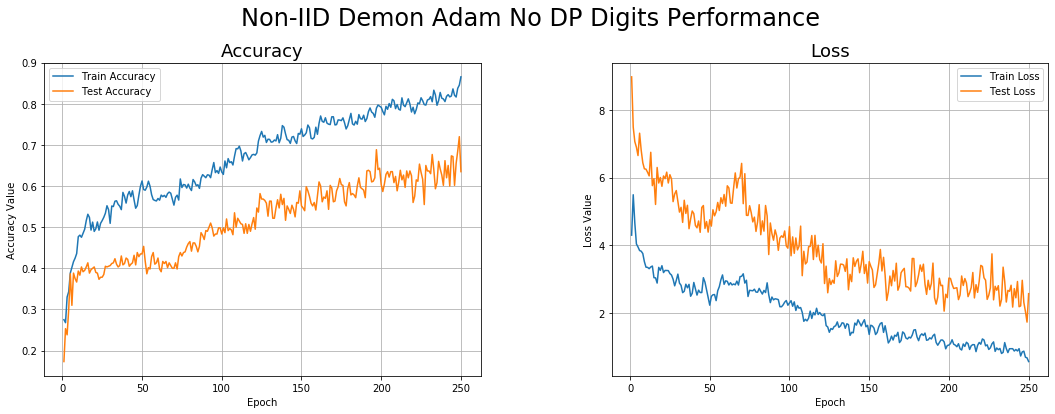

In [137]:
f = plot(epochs, "Non-IID Demon Adam No DP Digits Performance", history)

In [138]:
save(history, server_model, f, "NONIID_DEMON_ADAM_NODP_DIGITS")

### NONIID-DEMONADAM-DP-SPEAKERS

In [144]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)
criterion = torch.nn.CrossEntropyLoss()

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon=True
epochs = 400

optimizer = torch.optim.Adam(server_model.fc.parameters(), lr=server_lr, betas=(beta1, beta2))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

privacy_engine = PrivacyEngine(
    server_model,
    batch_size=batch_size,
    #sample_rate=batch_size/2400,
    sample_size=2400,
    epochs=epochs,
    max_grad_norm=1.0,
    noise_multiplier=1.3,
    alphas=[1, 10, 100]
)
privacy_engine.attach(optimizer)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

/home/nulven/privacyml/opacus/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/home/nulven/privacyml/opacus/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [145]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_speakers_dls, 
                                server_model, server_opt, server_lr, validation_dl,
                                criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 2.2713, train_acc : 0.1539, test_loss : 2.2685, test_acc : 0.1533
Epoch 2 - train_loss : 2.2717, train_acc : 0.1484, test_loss : 2.2718, test_acc : 0.1667
Epoch 3 - train_loss : 2.2496, train_acc : 0.1792, test_loss : 2.2683, test_acc : 0.1567
Epoch 4 - train_loss : 2.2522, train_acc : 0.1644, test_loss : 2.3054, test_acc : 0.1400
Epoch 5 - train_loss : 2.2313, train_acc : 0.1678, test_loss : 2.3041, test_acc : 0.1600
Epoch 6 - train_loss : 2.2502, train_acc : 0.1907, test_loss : 2.3760, test_acc : 0.1567
Epoch 7 - train_loss : 2.2431, train_acc : 0.1684, test_loss : 2.3709, test_acc : 0.1583
Epoch 8 - train_loss : 2.2602, train_acc : 0.1778, test_loss : 2.3541, test_acc : 0.1650
Epoch 9 - train_loss : 2.2958, train_acc : 0.1729, test_loss : 2.3723, test_acc : 0.1717
Epoch 10 - train_loss : 2.2702, train_acc : 0.1995, test_loss : 2.3959, test_acc : 0.1833
Epoch 11 - train_loss : 2.3344, train_acc : 0.1629, test_loss : 2.4043, test_acc : 0.1750
Epoch 12 - train_lo

Epoch 93 - train_loss : 2.9637, train_acc : 0.1795, test_loss : 3.3064, test_acc : 0.1683
Epoch 94 - train_loss : 2.8716, train_acc : 0.2000, test_loss : 3.2015, test_acc : 0.1800
Epoch 95 - train_loss : 2.9237, train_acc : 0.1830, test_loss : 3.2574, test_acc : 0.1683
Epoch 96 - train_loss : 2.9738, train_acc : 0.2055, test_loss : 3.2549, test_acc : 0.1767
Epoch 97 - train_loss : 2.9735, train_acc : 0.1826, test_loss : 3.1988, test_acc : 0.1517
Epoch 98 - train_loss : 2.9552, train_acc : 0.2078, test_loss : 3.2875, test_acc : 0.1550
Epoch 99 - train_loss : 3.0187, train_acc : 0.1869, test_loss : 3.1923, test_acc : 0.1717
Epoch 100 - train_loss : 3.0680, train_acc : 0.1984, test_loss : 3.2750, test_acc : 0.1883
Epoch 101 - train_loss : 3.0581, train_acc : 0.1850, test_loss : 3.2663, test_acc : 0.1883
Epoch 102 - train_loss : 3.0547, train_acc : 0.1915, test_loss : 3.2489, test_acc : 0.1950
Epoch 103 - train_loss : 3.0004, train_acc : 0.1927, test_loss : 3.2449, test_acc : 0.1900
Epoch 

KeyboardInterrupt: 

In [ ]:
f = plot(epochs, "Non-IID Demon Adam DP Speakers Performace", history)

In [ ]:
save(history, server_model, f, "NONIID_DEMON_ADAM_DP_SPEAKERS")

### NONIID-DEMONADAM-DP-DIGITS

In [146]:
from types import MethodType
server_model = models.resnet50(pretrained=True)
server_model.forward_half = MethodType(forward_half, server_model)

for param in server_model.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = server_model.fc.in_features
server_model.fc = torch.nn.Linear(num_ftrs, 10)
if device:
    server_model = server_model.cuda(device)

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon=True
epochs = 350

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(server_model.fc.parameters(), lr=server_lr, betas=(beta1, beta2))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

privacy_engine = PrivacyEngine(
    server_model,
    batch_size=batch_size,
    #sample_rate=batch_size/2400,
    sample_size=2400,
    epochs=epochs,
    max_grad_norm=1.0,
    noise_multiplier=1.3,
    alphas=[1, 10, 100]
)
privacy_engine.attach(optimizer)

client_models, client_optimizers = make_clients(n, server_model, optimizer)

/home/nulven/privacyml/opacus/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/home/nulven/privacyml/opacus/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [147]:
history = fit_federated(epochs, client_models, client_optimizers, noniid_digits_dls, 
                                server_model, server_opt, server_lr, validation_dl,
                                criterion, beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 2.6076, train_acc : 0.2247, test_loss : 2.4683, test_acc : 0.1450
Epoch 2 - train_loss : 2.5194, train_acc : 0.1823, test_loss : 2.4209, test_acc : 0.2117
Epoch 3 - train_loss : 2.5072, train_acc : 0.1934, test_loss : 2.2910, test_acc : 0.2517
Epoch 4 - train_loss : 2.4169, train_acc : 0.1845, test_loss : 2.2935, test_acc : 0.2467
Epoch 5 - train_loss : 2.3540, train_acc : 0.2093, test_loss : 2.1576, test_acc : 0.2817
Epoch 6 - train_loss : 2.3734, train_acc : 0.2189, test_loss : 2.1366, test_acc : 0.2767
Epoch 7 - train_loss : 2.3075, train_acc : 0.2234, test_loss : 2.0928, test_acc : 0.3017
Epoch 8 - train_loss : 2.2566, train_acc : 0.2499, test_loss : 2.1229, test_acc : 0.2933
Epoch 9 - train_loss : 2.3023, train_acc : 0.2522, test_loss : 2.1140, test_acc : 0.2667
Epoch 10 - train_loss : 2.2476, train_acc : 0.2524, test_loss : 2.0996, test_acc : 0.2817
Epoch 11 - train_loss : 2.1957, train_acc : 0.2731, test_loss : 2.0925, test_acc : 0.2983
Epoch 12 - train_lo

Epoch 93 - train_loss : 1.9560, train_acc : 0.4697, test_loss : 1.7858, test_acc : 0.4783
Epoch 94 - train_loss : 2.0337, train_acc : 0.4417, test_loss : 1.7936, test_acc : 0.4950
Epoch 95 - train_loss : 2.0519, train_acc : 0.4442, test_loss : 1.8333, test_acc : 0.4850
Epoch 96 - train_loss : 2.0453, train_acc : 0.4522, test_loss : 1.8591, test_acc : 0.4800
Epoch 97 - train_loss : 2.0184, train_acc : 0.4542, test_loss : 1.8494, test_acc : 0.4567
Epoch 98 - train_loss : 2.0587, train_acc : 0.4516, test_loss : 1.8143, test_acc : 0.4733
Epoch 99 - train_loss : 2.0418, train_acc : 0.4389, test_loss : 1.8136, test_acc : 0.4933
Epoch 100 - train_loss : 2.0516, train_acc : 0.4476, test_loss : 1.8711, test_acc : 0.4583
Epoch 101 - train_loss : 2.0478, train_acc : 0.4497, test_loss : 1.9058, test_acc : 0.4550
Epoch 102 - train_loss : 2.0173, train_acc : 0.4530, test_loss : 1.9363, test_acc : 0.4417
Epoch 103 - train_loss : 2.1100, train_acc : 0.4394, test_loss : 1.8942, test_acc : 0.4500
Epoch 

Epoch 184 - train_loss : 2.1437, train_acc : 0.4813, test_loss : 1.7511, test_acc : 0.5350
Epoch 185 - train_loss : 2.0824, train_acc : 0.4980, test_loss : 1.7130, test_acc : 0.5550
Epoch 186 - train_loss : 2.0790, train_acc : 0.4963, test_loss : 1.7416, test_acc : 0.5500
Epoch 187 - train_loss : 1.9921, train_acc : 0.5240, test_loss : 1.7094, test_acc : 0.5567
Epoch 188 - train_loss : 2.0523, train_acc : 0.5126, test_loss : 1.7254, test_acc : 0.5500
Epoch 189 - train_loss : 2.1131, train_acc : 0.5064, test_loss : 1.7708, test_acc : 0.5600
Epoch 190 - train_loss : 2.0368, train_acc : 0.5232, test_loss : 1.6923, test_acc : 0.5700
Epoch 191 - train_loss : 2.0156, train_acc : 0.5133, test_loss : 1.7316, test_acc : 0.5450
Epoch 192 - train_loss : 2.1009, train_acc : 0.5077, test_loss : 1.7417, test_acc : 0.5450
Epoch 193 - train_loss : 2.0411, train_acc : 0.5146, test_loss : 1.7297, test_acc : 0.5600
Epoch 194 - train_loss : 2.0702, train_acc : 0.5043, test_loss : 1.6762, test_acc : 0.5633

Epoch 275 - train_loss : 2.0296, train_acc : 0.5433, test_loss : 1.8346, test_acc : 0.5767
Epoch 276 - train_loss : 2.1030, train_acc : 0.5385, test_loss : 1.8487, test_acc : 0.5733
Epoch 277 - train_loss : 2.0797, train_acc : 0.5382, test_loss : 1.8062, test_acc : 0.5700
Epoch 278 - train_loss : 1.9977, train_acc : 0.5554, test_loss : 1.8785, test_acc : 0.5717
Epoch 279 - train_loss : 1.9932, train_acc : 0.5606, test_loss : 1.8747, test_acc : 0.5750
Epoch 280 - train_loss : 2.0084, train_acc : 0.5588, test_loss : 1.9964, test_acc : 0.5733
Epoch 281 - train_loss : 1.9786, train_acc : 0.5630, test_loss : 1.9582, test_acc : 0.5783
Epoch 282 - train_loss : 2.0700, train_acc : 0.5488, test_loss : 1.9728, test_acc : 0.5700
Epoch 283 - train_loss : 2.0439, train_acc : 0.5537, test_loss : 1.8966, test_acc : 0.5633
Epoch 284 - train_loss : 2.0307, train_acc : 0.5611, test_loss : 1.9114, test_acc : 0.5700
Epoch 285 - train_loss : 2.0114, train_acc : 0.5646, test_loss : 1.9109, test_acc : 0.5717

In [150]:
dp_history=history
dp_model=server_model

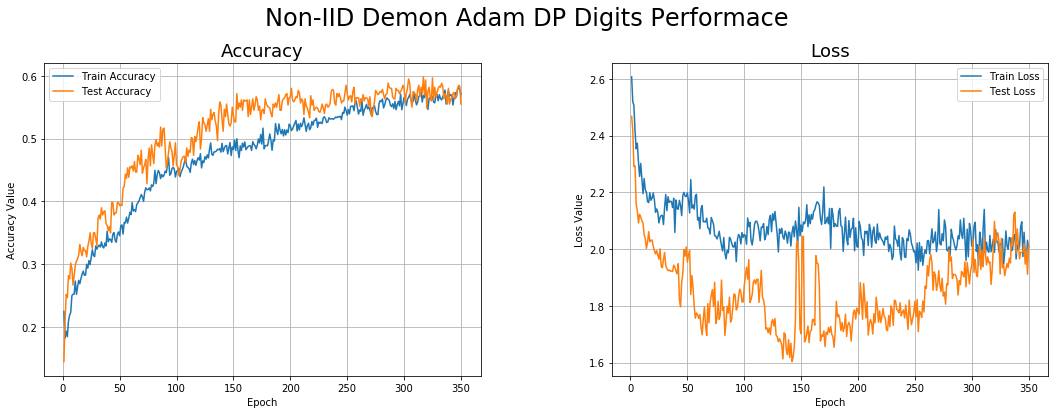

In [151]:
f = plot(epochs, "Non-IID Demon Adam DP Digits Performace ", dp_history)

In [ ]:
save(history, server_model, f, "NONIID_DEMON_ADAM_DP_DIGITS")

# Attacks

In [ ]:
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    in_channels=64,
                    out_channels=64,
                    kernel_size=7,
                    padding=3,
                    stride=2,
                    output_padding=1,
                ),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(
                    in_channels=64, out_channels=3, kernel_size=6, padding=2, stride=2,
                ),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def train_attacker(attack_model, target_model, dl):
    # Train attacker
    attack_optim = torch.optim.Adam(attacker.parameters(), lr=server_lr)

    for epoch in range(epochs):
        for data, targets in dl:
            data.float()
            targets.float()

            attack_optim.zero_grad()

            # We intercept the output of the mobile device's model
            # This is the input of our attack model
            with torch.no_grad():
                attack_input = target_model.forward_half(data.cuda(device))

            output = attack_model(attack_input.cuda(2))
            #print(output.shape)
            #print(data.shape)
            loss = ((output - data.cuda(2))**2).mean()  # We want our reconstructed image to look as much like the original image as possible
            loss.backward()
            attack_optim.step()
            print(f'Epoch {epoch} - train_loss : {loss:.4f}')

In [ ]:
def plot_images(
    tensors,
):
    """
    Plot normalised MNIST tensors as images
    """
    fig = plt.figure(figsize=(10, 5))

    n_tensors = len(tensors)
    n_cols = min(n_tensors, 4)
    n_rows = int((n_tensors - 1) / 4) + 1

    # De-normalise an MNIST tensor
    mu = torch.tensor([0.1307], dtype=torch.float32)
    sigma = torch.tensor([0.3081], dtype=torch.float32)
    Unnormalise = transforms.Normalize((-mu / sigma).tolist(), (1.0 / sigma).tolist())

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            if idx > n_tensors - 1:
                break

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = Unnormalise(tensors[idx])

            # Clip image values so we can plot
            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            tensor = tensor.squeeze(0)  # remove batch dim                      

            ax.imshow(transforms.ToPILImage()(tensor), interpolation="bicubic")

    plt.tight_layout()
    plt.show()

In [ ]:
'''
attacker = AttackModel()
attacker = attacker.cuda(2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(attacker.parameters(), lr=0.05, momentum=0.9)

server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
epochs = 250
'''

In [ ]:
#models.ResNet.forward_half = MethodType(forward_half, models.ResNet)

In [ ]:
#from types import MethodType
#target = torch.load('NonIID_Adam.pth').cuda(0)
#target.forward_half = MethodType(forward_half, target)

In [ ]:
#del(attacker)

In [ ]:
#train_attacker(attacker, target, validation_dl)

In [ ]:
def attack(attack_model, target_model, dataset, idxs):
    images = []
    loss = []

    for datum_idx in idxs:
        actual_image, _ = dataset[datum_idx]

        with torch.no_grad():
            target_output = target_model.forward_half(actual_image.unsqueeze(0).cuda(device))
            reconstructed_image = attack_model(target_output.cuda(2)).squeeze(0)
            loss.append(((actual_image.cpu() - reconstructed_image.cpu())**2).mean())

        images.append(actual_image.cpu())
        images.append(reconstructed_image.cpu())

    plot_images(images)
    print(sum(loss)/len(loss))

In [ ]:
#train_dataset = HeartbeatDataset("/data/mnist/audio_plots",train_ds,transform=ds_trans)
#attack(attacker, target, dataset, range(6))

# Attacker Classifier

In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self, root_dir, annotation_file, attack_model, target_model, transform=None):
        self.root_dir = root_dir
        self.annotations = annotation_file
        self.attack_model = attack_model
        self.target_model = target_model
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id+'.png')).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        with torch.no_grad():
            target_output = self.target_model.forward_half(img.unsqueeze(0))
            rec_img = self.attack_model(target_output).squeeze(0)
        y_label = torch.tensor(float(self.annotations.iloc[index, 1])).type(torch.LongTensor)

        return (rec_img, y_label)

In [ ]:
'''
classifier = models.resnet50(pretrained=True)

for param in classifier.parameters():
    param.requires_grad = False

# new final layer with classes
num_ftrs = classifier.fc.in_features
classifier.fc = torch.nn.Linear(num_ftrs, 6)
if device:
    classifier = classifier.cuda(device)
criterion = torch.nn.CrossEntropyLoss()

server_opt = 'sgd'
server_lr = 0.05
beta1 = 1
beta2 = 1
epsilon = 1e-8
epochs = 250

optimizer = torch.optim.SGD(classifier.fc.parameters(), lr=0.05)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
'''

In [ ]:
'''
files = os.listdir('/data/mnist/audio_mnist')

names_vec = {'lucas': 0, 'george': 1, 'nicolas': 2, 'yweweler': 3, 'theo': 4, 'jackson': 5}
digits = [int(file[0]) for file in files]
names = [names_vec[file.split('_')[1]] for file in files]
d = {'fname': files, 'label': names}
name_labels = pd.DataFrame(data=d)
'''

In [ ]:
'''
from tqdm import tqdm 
import time
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

for file in tqdm(files):
  img = Image.open(os.path.join('/data/mnist/audio_plots', file+'.png')).convert("RGB")
  img = ds_trans(img)
  with torch.no_grad():
    target_output = target.forward_half(img.unsqueeze(0).cuda(device))
    rec_img = attacker(target_output.cuda(2)).squeeze(0)
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  ax = fig.add_subplot(111)
  plt.margins(0,0)
  plt.axis('off')

  fig = plt.figure(figsize=(10, 5))

  # De-normalise an MNIST tensor
  mu = torch.tensor([0.1307], dtype=torch.float32)
  sigma = torch.tensor([0.3081], dtype=torch.float32)
  Unnormalise = transforms.Normalize((-mu / sigma).tolist(), (1.0 / sigma).tolist())

  tensor = Unnormalise(rec_img.cpu())

  # Clip image values so we can plot
  tensor[tensor < 0] = 0
  tensor[tensor > 1] = 1
  tensor = tensor.squeeze(0)  # remove batch dim                      

  ax.imshow(transforms.ToPILImage()(tensor), interpolation="bicubic")

  plt.savefig('/data/mnist/rec_audio_plots/' + file + '.png',bbox_inches='tight',pad_inches = 0)
  # time.sleep(0.01)
'''

In [ ]:
'''
train_idxs, validation_idxs = torch.utils.data.random_split(list(name_labels.index), [2400, 600])
train_ds, validation_ds = name_labels.iloc[list(train_idxs)], name_labels.iloc[list(validation_idxs)]
train_ds, validation_ds = train_ds.reset_index(drop=True), validation_ds.reset_index(drop=True)
#name_train_set = ClassifierDataset("/data/mnist/audio_plots",train_ds,attacker.cpu(),target.cpu(),transform=ds_trans)
name_train_set = HeartbeatDataset("/data/mnist/rec_audio_plots",train_ds,transform=ds_trans)
name_train_dl = DataLoader(name_train_set, 100, shuffle=True, num_workers=0, pin_memory=True)
#name_validation_set = ClassifierDataset("/data/mnist/audio_plots",validation_ds,attacker.cpu(),target.cpu(),transform=ds_trans)
name_validation_set = HeartbeatDataset("/data/mnist/rec_audio_plots",validation_ds,transform=ds_trans)
name_validation_dl = DataLoader(name_validation_set, 100, shuffle=True, num_workers=0, pin_memory=True)
'''

In [ ]:
#history = fit(epochs, classifier, optimizer, criterion, name_train_dl, name_validation_dl)